In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install spopt

In [ ]:
from spopt.locate import PMedian
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/P_median/geo.csv')

In [ ]:
df = df.sort_values(by='배송시간', ascending=False)

In [ ]:
df = df.sort_values(by='배송시간', ascending=False)
df = df.drop('Unnamed: 0',axis=1)

In [ ]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 5 # quantity supply points

P_FACILITIES = 5

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False) # see solvers available in pulp reference

In [ ]:
lattice = spaghetti.regular_lattice((0, 0, 180, 180), 10, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [ ]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

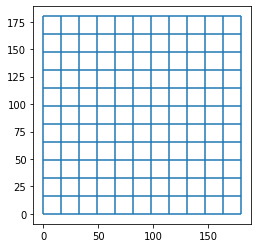

In [ ]:
street.plot()

In [ ]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

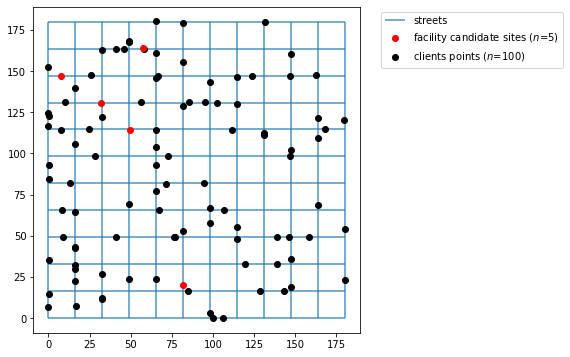

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [ ]:
ai = numpy.random.randint(1, 12, CLIENT_COUNT)

In [ ]:
ai

array([ 1, 10,  5,  1, 11,  1,  5,  5,  4,  5, 10, 11,  5,  7,  8,  1, 11,
        6,  8,  6,  3,  2,  2,  2,  7,  8,  7,  5,  4,  2,  1, 10, 11,  7,
        8,  5,  1, 10,  7,  3,  4,  2,  3,  1,  8,  2, 10,  7,  9,  4, 11,
        2, 11,  4,  3,  7,  3,  5,  9,  5,  9,  1,  2, 11,  5,  1,  2, 10,
       11,  6, 10,  3,  6,  9,  5,  7,  8, 11, 10, 11, 10, 11,  2,  5,  6,
        2,  4,  1, 11,  2,  3,  9,  1,  1,  7, 11,  3,  6, 10, 11])

In [ ]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

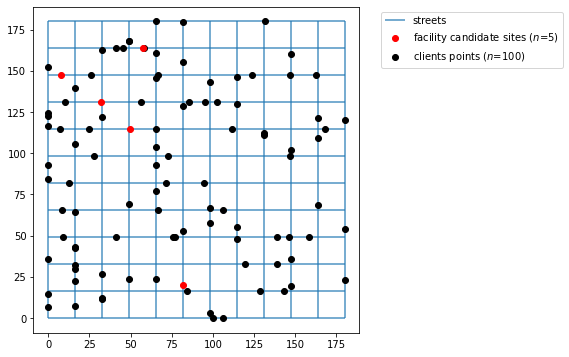

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [ ]:
cost_matrix

array([[249.2135153 , 105.53622962, 208.15183283, 215.63198916,
        174.26052459],
       [ 61.99041138, 154.33230293,  70.32482112, 128.29921025,
         71.48885665],
       [ 70.2859683 , 146.036746  ,  78.62037804, 136.59476718,
         79.78441357],
       [188.17930474, 142.68383723, 147.11762227, 154.5977786 ,
        113.22631402],
       [185.11531915, 147.09859946, 144.05363668, 151.533793  ,
        110.16232843],
       [108.04204715, 158.71732601,  97.6965656 ,  74.46052101,
         96.53253007],
       [ 94.52145531, 139.51064512,  78.48988471,  60.93992917,
         77.32584918],
       [ 59.23764195, 142.06718575,  48.31915261,  25.65611581,
         47.15511709],
       [ 71.44979775, 156.86342114,  63.11538801,  10.85988042,
         61.95135248],
       [159.78011235, 139.70653354, 118.71842988, 126.19858621,
         84.82712164],
       [245.80392834,  69.39936993, 204.74224587, 212.2224022 ,
        170.85093763],
       [ 12.56763006, 213.87245777,  53.629

In [ ]:
pmedian_from_cost_matrix = PMedian.from_cost_matrix(cost_matrix, ai, p_facilities=P_FACILITIES)
pmedian_from_cost_matrix = pmedian_from_cost_matrix.solve(solver)

In [ ]:
pmedian_from_cost_matrix

In [ ]:
df['geo']

0              (37.5262, 126.8959)
1              (35.8584, 128.6305)
2              (35.8865, 128.6355)
3              (37.5262, 126.8959)
4        (35.8692588, 128.6059471)
                   ...            
16549          (35.2429, 129.0926)
16550          (35.2429, 129.0926)
16551          (35.2429, 129.0926)
16552    (37.5014422, 126.7660139)
16553    (35.8242772, 127.1481147)
Name: geo, Length: 16554, dtype: object

In [ ]:
import geopandas as gpd

In [ ]:
from decimal import Decimal

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/P_median/geo.csv')

In [ ]:
df5 = pd.read_csv('/content/drive/MyDrive/P_median/df5.csv')

In [ ]:
df5

,Unnamed: 0,index,주소,배송시간,score_x,수량,score_y,판매가,판매가_1,score,all_score,geo,geo_lat,geo_long
0,0,67,서울특별시 강남구,4,1.6000000,10,3.0000000,"24,918,970.0000000",249,74.7000000,79.3000000,"(37.5177, 127.0473)",37.5177000,127.0473000
1,1,53,대전광역시 서구,4,1.6000000,8,2.4000000,"22,690,370.0000000",226,67.8000000,71.8000000,"(36.2973919, 127.3544493)",36.2973919,127.3544493
2,2,54,경상남도 창원시,4,1.6000000,9,2.7000000,"21,693,170.0000000",216,64.8000000,69.1000000,"(35.227956, 128.6818586)",35.2279560,128.6818586
3,3,31,부산광역시 부산진구,4,1.6000000,9,2.7000000,"21,087,090.0000000",210,63.0000000,67.3000000,"(35.1632335, 129.0529462)",35.1632335,129.0529462
4,4,66,경기도 수원시,4,1.6000000,9,2.7000000,"20,689,180.0000000",206,61.8000000,66.1000000,"(37.2633325, 127.0287472)",37.2633325,127.0287472
5,5,77,광주광역시 서구,4,1.6000000,10,3.0000000,"19,445,280.0000000",194,58.2000000,62.8000000,"(35.1521401, 126.8900561)",35.1521401,126.8900561
6,6,33,서울특별시 마포구,4,1.6000000,8,2.4000000,"19,568,130.0000000",195,58.5000000,62.5000000,"(37.566571, 126.9015317)",37.5665710,126.9015317
7,7,20,대전광역시 동구,4,1.6000000,8,2.4000000,"19,140,570.0000000",191,57.3000000,61.3000000,"(36.3122, 127.4551)",36.3122000,127.4551000
8,8,32,서울특별시 영등포구,4,1.6000000,7,2.1000000,"18,391,450.0000000",183,54.9000000,58.6000000,"(37.5262, 126.8959)",37.5262000,126.8959000
9,9,171,부산광역시 연제구,4,1.6000000,7,2.1000000,"16,498,170.0000000",164,49.2000000,52.9000000,"(35.1765, 129.0793)",35.1765000,129.0793000


In [ ]:
df = df.sort_values(by='배송시간', ascending=False).reset_index()
df = df.drop('index',axis=1)

In [ ]:
df = df.drop('Unnamed: 0',axis=1)

In [ ]:
df

,geo,주소,판매가,순이익,수량,배송시간
0,"(37.5262, 126.8959)",서울특별시 영등포구,"59,200.0000000","15,200.0000000",2.0000000,9 days
1,"(35.8584, 128.6305)",대구광역시 수성구,"78,000.0000000","22,560.0000000",1.0000000,9 days
2,"(35.8865, 128.6355)",대구광역시 동구,"109,000.0000000","23,200.0000000",1.0000000,9 days
3,"(37.5262, 126.8959)",서울특별시 영등포구,"53,100.0000000","10,200.0000000",1.0000000,9 days
4,"(35.8692588, 128.6059471)",대구광역시 중구,"47,000.0000000","5,200.0000000",1.0000000,8 days
...,...,...,...,...,...,...
16549,"(35.2429, 129.0926)",부산광역시 금정구,"53,300.0000000","9,300.0000000",1.0000000,0 days
16550,"(35.2429, 129.0926)",부산광역시 금정구,"68,100.0000000","18,600.0000000",1.0000000,0 days
16551,"(35.2429, 129.0926)",부산광역시 금정구,"105,500.0000000","20,250.0000000",1.0000000,0 days
16552,"(37.5014422, 126.7660139)",경기도 부천시,"84,600.0000000","15,300.0000000",1.0000000,0 days


In [ ]:
def func3(row):
    return row.split(' ')[0]

In [ ]:
df['배송시간'] = df['배송시간'].apply(func3).astype(int)

In [ ]:
def func1(row):
    row = row.split(',')[0]
    row = row.replace('(','')
    return row

df['geo_la'] = df['geo'].apply(func1)

def func2(row):
    row = row.split(',')[1]
    row = row.replace(')','')
    return row

df['geo_lo'] = df['geo'].apply(func2)

In [ ]:
pd.options.display.float_format = '{:,.7f}'.format

In [ ]:
df['geo_lo']

0            126.8959
1            128.6305
2            128.6355
3            126.8959
4         128.6059471
             ...     
16549        129.0926
16550        129.0926
16551        129.0926
16552     126.7660139
16553     127.1481147
Name: geo_lo, Length: 16554, dtype: object

In [ ]:
df['geo_lo'] = df['geo_lo'].astype(float)

In [ ]:
df['geo_la'] = df['geo_la'].astype(float)

In [ ]:
df5['geometry'] = df5.apply(lambda row : Point([row['geo_lat'], row['geo_long']]), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
df5 = gpd.GeoDataFrame(df5, geometry='geometry')

In [ ]:
pt_119 = df5.copy()

In [ ]:
clients_snapped['geometry'] = pt_119['geometry']

In [ ]:
clients_snapped['weights'] = (pt_119['all_score']/10).astype(int)

In [ ]:
pt_119

,Unnamed: 0,index,주소,배송시간,score_x,수량,score_y,판매가,판매가_1,score,all_score,geo,geo_lat,geo_long,geometry
0,0,67,서울특별시 강남구,4,1.6000000,10,3.0000000,"24,918,970.0000000",249,74.7000000,79.3000000,"(37.5177, 127.0473)",37.5177000,127.0473000,POINT (37.518 127.047)
1,1,53,대전광역시 서구,4,1.6000000,8,2.4000000,"22,690,370.0000000",226,67.8000000,71.8000000,"(36.2973919, 127.3544493)",36.2973919,127.3544493,POINT (36.297 127.354)
2,2,54,경상남도 창원시,4,1.6000000,9,2.7000000,"21,693,170.0000000",216,64.8000000,69.1000000,"(35.227956, 128.6818586)",35.2279560,128.6818586,POINT (35.228 128.682)
3,3,31,부산광역시 부산진구,4,1.6000000,9,2.7000000,"21,087,090.0000000",210,63.0000000,67.3000000,"(35.1632335, 129.0529462)",35.1632335,129.0529462,POINT (35.163 129.053)
4,4,66,경기도 수원시,4,1.6000000,9,2.7000000,"20,689,180.0000000",206,61.8000000,66.1000000,"(37.2633325, 127.0287472)",37.2633325,127.0287472,POINT (37.263 127.029)
5,5,77,광주광역시 서구,4,1.6000000,10,3.0000000,"19,445,280.0000000",194,58.2000000,62.8000000,"(35.1521401, 126.8900561)",35.1521401,126.8900561,POINT (35.152 126.890)
6,6,33,서울특별시 마포구,4,1.6000000,8,2.4000000,"19,568,130.0000000",195,58.5000000,62.5000000,"(37.566571, 126.9015317)",37.5665710,126.9015317,POINT (37.567 126.902)
7,7,20,대전광역시 동구,4,1.6000000,8,2.4000000,"19,140,570.0000000",191,57.3000000,61.3000000,"(36.3122, 127.4551)",36.3122000,127.4551000,POINT (36.312 127.455)
8,8,32,서울특별시 영등포구,4,1.6000000,7,2.1000000,"18,391,450.0000000",183,54.9000000,58.6000000,"(37.5262, 126.8959)",37.5262000,126.8959000,POINT (37.526 126.896)
9,9,171,부산광역시 연제구,4,1.6000000,7,2.1000000,"16,498,170.0000000",164,49.2000000,52.9000000,"(35.1765, 129.0793)",35.1765000,129.0793000,POINT (35.176 129.079)


In [ ]:
clients_snapped = clients_snapped.iloc[:20]

In [ ]:
pmedian_from_geodataframe = PMedian.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    p_facilities=P_FACILITIES,
    distance_metric="euclidean"
)
pmedian_from_geodataframe = pmedian_from_geodataframe.solve(solver)

In [ ]:
pmedian_from_geodataframe

In [ ]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
]

def plot_results(model, facility_points):
    arr_points = []
    fac_sites = []

    for i in range(FACILITY_COUNT):
        if model.fac2cli[i]:

            geom = client_points.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(10,10))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])

        label = f"coverage_points by y{fac_sites[i]}"
        legend_elements.append(Patch(facecolor=dv_colors[i], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=dv_colors[i], label=label)
        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])

        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"y{fac_sites[i]} facility selected",
        ))

    plt.title("P-Median", fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

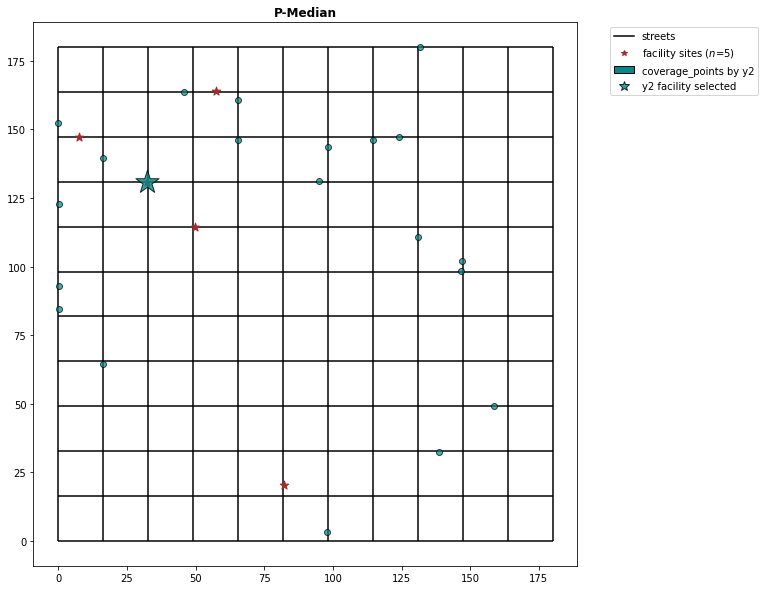

In [ ]:
pmedian_from_geodataframe.facility_client_array()
plot_results(pmedian_from_geodataframe, facility_points)

In [ ]:
facility_points

,geometry
0,POINT (7.509 147.163)
1,POINT (82.006 20.277)
2,POINT (32.207 130.820)
3,POINT (57.454 163.801)
4,POINT (49.735 114.440)
